### Load and install necessary packages

In [1]:
# !pip install --user spacy
# !python -m spacy download en

In [2]:
# !pip install --user gensim
# !pip install --user TextBlob,gingerit,wordcloud, wordsegment

In [3]:
# !pip install --user textblob
#!pip install --user gingerit
#!pip install --user wordcloud

In [4]:
%matplotlib inline
import numpy as np
import re
import collections
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import spacy
import warnings
import gensim
from textblob import TextBlob
from IPython.core.debugger import Tracer
from gingerit.gingerit import GingerIt
from wordcloud import WordCloud, STOPWORDS
# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()
# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer("english")
warnings.filterwarnings('ignore')

In [5]:
#!pip install --user gensim pyLDAvis wordlcoud

In [6]:
#nltk.download('wordnet')
#nltk.download('stopwords')

### Import helper functions from scripts

In [7]:
import sys,os
sys.path.insert(0, '../scripts/')
#from preprocess_modular import clean_preprocess,read_prepare_data
def read_prepare_data(data_path):
    #Add asset from file system
    complaints_df = pd.read_csv(data_path,encoding='ISO-8859-1')
    #complaints_df.columns
    columns= ['ConcernID','IssueID','ConcernDescription','IssueDescription','ResolutionDescription']
    keywords_df = complaints_df[columns]
    keywords_df['keyword_corpus'] = keywords_df['ConcernDescription']+"."+keywords_df['IssueDescription']+"."+keywords_df['ResolutionDescription']
    keywords_df['keyword_corpus'] = keywords_df[['ConcernDescription','IssueDescription','ResolutionDescription']].fillna('').sum(axis=1)
    return keywords_df,complaints_df

In [301]:
complaints_df['Breach'].value_counts()

No           24609
No            6687
Possible      3248
Possible        97
Yes             74
 No              5
possible         1
Name: Breach, dtype: int64

### Load Complaints Dataset

In [8]:
keywords_df,complaints_df = read_prepare_data(data_path=os.environ['DSX_PROJECT_DIR']+
                       '/datasets/Complaints_All_2018_Consolidated_Final.csv')

#keywords_df.tail(30)


In [9]:
keywords_df.drop(keywords_df.index[34721:],inplace=True)

In [10]:
keywords_df.head(3)

,ConcernID,IssueID,ConcernDescription,IssueDescription,ResolutionDescription,keyword_corpus
0,964163,1016404,"Unclaimed Monies - ANZ Account - $1,978,74. I...",unclaimed money request,CA - 5 September 2017 - Feedback noted. Estate...,"Unclaimed Monies - ANZ Account - $1,978,74. I..."
1,965539,1017305,Customer is unable to pay his business loans s...,customer is wanting legal actions stopped,Customer Advocate- confirmed with customer tha...,Customer is unable to pay his business loans s...
2,967004,1015985,I am writing to express our grave concern abou...,Loan application declined.,23/08/2017 - Requested further information fro...,I am writing to express our grave concern abou...


In [11]:
temp_df = keywords_df.copy()

# NLP Pre-processing

### Load NLTK stop words and custom stop words list

In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

In [13]:
stop_words = set(stop_words)

In [14]:
#!pip install --user gensim
from gensim.parsing.preprocessing import STOPWORDS
custom_stopwords = ['anz','account','customer','card','bank','complaint','january','february','march','april','may','june','july','august',
                   'september','october','november','december','customers']
#custom_stopwords = ['anz','account','customer','bank','complaint']
my_stop_words = STOPWORDS.union(set(custom_stopwords))
store 

### Preprocessing of Data

In [15]:
from gensim.parsing import preprocessing as pp

pp_list = [
    lambda x: x.lower(),
    pp.strip_tags,
    pp.strip_multiple_whitespaces,
    pp.strip_punctuation,
    pp.strip_short,
    pp.remove_stopwords,
    pp.strip_numeric
          ]

def tokenizer(line):
    tokens = pp.preprocess_string(line, filters=pp_list)
    return tokens

def remove_custom_stopwords(line,custom_stopwords):
    result = [val for i,val in line if val not in custom_stopwords]
    return result

            

In [16]:
def count_null_percategory(df):
    null_columns=df.columns[df.isnull().any()]
    return df[null_columns].isnull().sum()
    #print(keywords_df[keywords_df.isnull().any(axis=1)][null_columns].head(1))

In [17]:
count_null_percategory(keywords_df)

IssueID                  121
IssueDescription         121
ResolutionDescription    545
dtype: int64

In [18]:
len(keywords_df['keyword_corpus'])

34721

### Apply it on our dataset

In [19]:
%%time

train_texts = []
try:
    for index,line in enumerate(keywords_df['keyword_corpus']):
        tokens = tokenizer(line)
        tokenz = [val for i, val in enumerate(tokens) if val not in custom_stopwords]
        #tokens = remove_custom_stopwords(line,custom_stopwords)
        train_texts.append(tokenz)
        
except Exception as e:
    print(index,e)

CPU times: user 10.8 s, sys: 60 ms, total: 10.9 s
Wall time: 10.9 s


In [20]:
len(train_texts)

34721

In [21]:
#train_texts[0]

In [22]:
keywords_df['tokens'] = train_texts
keywords_df.head(5)

,ConcernID,IssueID,ConcernDescription,IssueDescription,ResolutionDescription,keyword_corpus,tokens
0,964163,1016404,"Unclaimed Monies - ANZ Account - $1,978,74. I...",unclaimed money request,CA - 5 September 2017 - Feedback noted. Estate...,"Unclaimed Monies - ANZ Account - $1,978,74. I...","[unclaimed, monies, emailing, london, sydney, ..."
1,965539,1017305,Customer is unable to pay his business loans s...,customer is wanting legal actions stopped,Customer Advocate- confirmed with customer tha...,Customer is unable to pay his business loans s...,"[unable, pay, business, loans, expected, compe..."
2,967004,1015985,I am writing to express our grave concern abou...,Loan application declined.,23/08/2017 - Requested further information fro...,I am writing to express our grave concern abou...,"[writing, express, grave, concern, processing,..."
3,968151,1019451,Customer request we return his documents as it...,Credit limit increase,28 August 2017 - Response issued advising that...,Customer request we return his documents as it...,"[request, return, documents, sensitive, inform..."
4,968359,1019784,Customer is disappointed with collections call...,Collections calls,CA - 1 September 2017- Response to customer an...,Customer is disappointed with collections call...,"[disappointed, collections, calls, receiving, ..."


## Visualize word cloud of all tokens

In [23]:
unigram_counter = collections.Counter(x for xs in train_texts for x in set(xs))

for stop_word in stop_words:
    if stop_word in unigram_counter:
        unigram_counter.pop(stop_word)

unigram_counter.most_common(10)

[('advised', 17916),
 ('credit', 13410),
 ('happy', 9959),
 ('branch', 9499),
 ('sent', 9295),
 ('closed', 8928),
 ('feedback', 8887),
 ('received', 8595),
 ('inconvenience', 8434),
 ('apologised', 7874)]

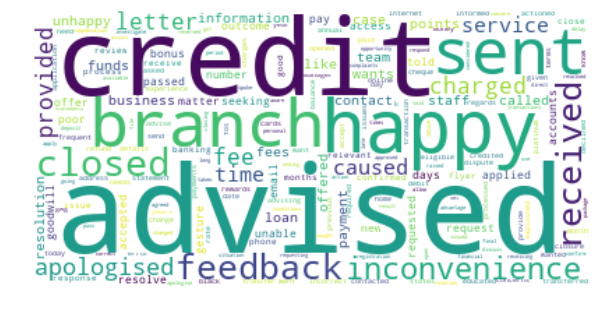

In [24]:
wc = WordCloud(background_color='white', random_state=42)

plt.figure(figsize=(10, 8))
plt.imshow(wc.fit_words(unigram_counter), interpolation='bilinear')
plt.axis("off")
plt.savefig('../datasets/total_wordcloud.png')
plt.show()

### Spellchecker and Slang Removal

In [25]:
%load_ext cython

### Phrase Modelling and advanced NLP Cleaning

In [26]:
%%cython

import gensim
from numba import jit, autojit

slang_hash = {'monies':'money','cust':'customer','cus':'customer','custome':'customer','fos':'financial_ombudsman_service',
              'afca':'australian_financial_complaints_authority', 'gtr':'guarantor','cad':'card','kbonus':'bonus','pch':'primary_card_holder',
             'rat':'rate','didnt':"did not",'feb':'February','isn':'is not'}

custom_bi_trigrams = {'break_free_package','financial_ombudsman_service','frequent_fly_points','eligible_bonus_points',
                      'business_select_package','platinum_card','frequent_flyer_black','bonus_point_offer','frequent_flyer_credit',
                      'reward_program_fee','residential_investment_property_loan','senior_personal_banker'}

def replace_slangs(lists):
    result = [slang_hash[word] if word in slang_hash else word for word in lists]
    return result

def get_phrases(lists):
    bigram = gensim.models.Phrases(lists)
    bigram_phraser = gensim.models.phrases.Phraser(bigram)
    tokens_ = bigram_phraser[lists]
    trigram = gensim.models.Phrases(tokens_)
    trigram_phraser = gensim.models.phrases.Phraser(trigram)
    return trigram_phraser,bigram_phraser

       
def lemmatize_process(lists,phrased):
    from wordsegment import load,segment
    load() #Load the Segmentation model
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer("english")
    bigram_phraser,trigram_phraser = get_phrases(lists)
    for each in lists:
        inter_res = replace_slangs(each)
        each1 = [segment(word) for word in inter_res]
        each2 = flatten_lists(each1)
        res= bigram_phraser[each2]
        #res= bigram_phraser[each]
        res = trigram_phraser[res]
        phrased.append([lemmatizer.lemmatize(word, pos='v') for word in res])
    return phrased

def remove_email_new_line(data):
    # Remove Emails
    import re
    data = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data]
    # Remove new line characters
    data = [re.sub('\s+', ' ', str(sent)) for sent in data]
    # Remove distracting single quotes
    data = [re.sub("\'", "", str(sent)) for sent in data]
    return data

def flatten_lists(lists):
    flat_list = [item for sublist in lists for item in sublist]
    return flat_list
    
def preprocess_phrase(lists):
    phrased=[]
    #train_text_final = clean(lists)
    phrased = lemmatize_process(lists,phrased)
    return phrased
                      
    

In [27]:
#!pip install --user wordsegment

In [28]:
import time
start = time.time()
phrased = preprocess_phrase(train_texts)
print((time.time()-start))

1012.9123854637146


In [29]:
import copy
phrased_copy = phrased.copy()

In [30]:
# get_phraser = get_phrases(train_text_final)
len(phrased)

34721

In [31]:
temp =[]
from gensim.parsing.preprocessing import strip_multiple_whitespaces,strip_short
for line in phrased:
    tmp =[]
    for each in line:
        if each not in my_stop_words:
            tmp.append(strip_short(each))
    temp.append(tmp)
        

    

In [32]:
phrased_final = temp

In [33]:
cleaned_list = []
for each in phrased_final:
    cleaned_list.append(list(filter(None, each)))

In [34]:
#cleaned_list.append(custom_bi_trigrams)

In [35]:
with open('../cleaned_list.txt', 'w') as f:
    for item in cleaned_list:
        f.write("%s\n" % item)

In [36]:
keywords_df['finalized_tokens'] = cleaned_list
keywords_df.head()


#keywords_df.drop(['dominant_topic','dominant_topic_probability','topic_label','topic_distribution_string','original labels'],axis =1 ,inplace=True)

,ConcernID,IssueID,ConcernDescription,IssueDescription,ResolutionDescription,keyword_corpus,tokens,finalized_tokens
0,964163,1016404,"Unclaimed Monies - ANZ Account - $1,978,74. I...",unclaimed money request,CA - 5 September 2017 - Feedback noted. Estate...,"Unclaimed Monies - ANZ Account - $1,978,74. I...","[unclaimed, monies, emailing, london, sydney, ...","[unclaimed_money, email, london, sydney, try, ..."
1,965539,1017305,Customer is unable to pay his business loans s...,customer is wanting legal actions stopped,Customer Advocate- confirmed with customer tha...,Customer is unable to pay his business loans s...,"[unable, pay, business, loans, expected, compe...","[unable, pay, business, loan, expect, compensa..."
2,967004,1015985,I am writing to express our grave concern abou...,Loan application declined.,23/08/2017 - Requested further information fro...,I am writing to express our grave concern abou...,"[writing, express, grave, concern, processing,...","[writing_express, grave, concern, process, loa..."
3,968151,1019451,Customer request we return his documents as it...,Credit limit increase,28 August 2017 - Response issued advising that...,Customer request we return his documents as it...,"[request, return, documents, sensitive, inform...","[request, return, document, sensitive_informat..."
4,968359,1019784,Customer is disappointed with collections call...,Collections calls,CA - 1 September 2017- Response to customer an...,Customer is disappointed with collections call...,"[disappointed, collections, calls, receiving, ...","[disappoint, collections_calls, receive, relat..."


In [433]:
%store cleaned_list

Stored 'cleaned_list' (list)


In [434]:
%store keywords_df

Stored 'keywords_df' (DataFrame)


In [435]:
%store complaints_df

Stored 'complaints_df' (DataFrame)


### Remove duplicate tokens to create corpus dictionary

In [37]:
def remove_duplicate_tokens(test):
    for each in test:
        train_texts_corp =[]
        train_texts_c.append(list(dict.fromkeys(each)))
    return train_texts_corp

### The Topic Model 

In [38]:
from gensim.corpora import Dictionary

# Create a dictionary(vocab) with all tokens
#dictionary = Dictionary(phrased_final)
dictionary = Dictionary(cleaned_list)

# Filter tokens which appear less than 5 times,
# and those which appear more than 50% of the time.
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Convert our documents to bag-of-words
#corpus = [dictionary.doc2bow(text) for text in phrased]
corpus = [dictionary.doc2bow(text) for text in cleaned_list]

In [312]:
%%time

from gensim.models import LdaModel

# Set random seed to reproduce results
np.random.seed(42)

NUM_TOPICS = 36

# Caution: the below parameters will take a long time to run
# First run it with default parameters
passes = 40
iterations = 400
eval_every = 50

# Increase the number of passes to get better results. But it'll takes more time
ldamodel = LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary,
                    passes=passes,
                   iterations=iterations,
                   eval_every=eval_every)

CPU times: user 16min 1s, sys: 288 ms, total: 16min 2s
Wall time: 16min 2s


In [145]:
# mallet_path = 'path/to/mallet-2.0.8/bin/mallet' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=dictionary)


In [337]:
%%time
def get_best_model():
    import operator
    from gensim.models import LdaModel
    from gensim.models import CoherenceModel

    models = []
    c_score = {}
    passes = 40
    iterations = 400
    eval_every = 50
    for i in range(15,40,5):
        #ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=i, id2word=dictionary)
        lda = LdaModel(corpus=corpus, num_topics=i, id2word=dictionary,
                        passes=passes,
                       iterations=iterations,
                       eval_every=eval_every)

        models.append(lda)

    for each in models:
#         coherence_model_lda = CoherenceModel(model=each, texts=cleaned_list, dictionary=dictionary, coherence='c_v')
#         coherence_lda = coherence_model_lda.get_coherence()
        print('\nPerplexity: ', ldamodel.log_perplexity(each))
        #print('\n Model---> {} Coherence Score: {}'.format(each,coherence_lda))
        c_score[each]= coherence_lda
     
    return c_score,models
    #return max(c_score.items(), key=operator.itemgetter(1))[0]
    

    
    
    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 25 µs


In [ ]:
%%time
c_score,models = get_best_model()

In [347]:
len(models)

9

In [349]:
([print(i,each.log_perplexity(corpus)) for i, each in enumerate(models)])

0 -7.434769702853471
1 -8.166421371755673
2 -8.457969101355365
3 -8.74222259769105
4 -8.996421944615031
5 -9.229978682877357
6 -9.514776017259944
7 -9.793260229137163
8 -10.070779475684436


[None, None, None, None, None, None, None, None, None]

### NMF Model

In [389]:
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.decomposition import NMF
# from sklearn.preprocessing import normalize

# vectorizer = CountVectorizer(analyzer='word', max_features=8000)
# data = [' '.join(text) for text in cleaned_list]
# x_counts = vectorizer.fit_transform(data)
# # Next, we set a TfIdf Transformer, and transform the counts with the model.
# transformer = TfidfTransformer(smooth_idf=False);
# x_tfidf = transformer.fit_transform(x_counts)
# xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

# num_topics = 35
# model = NMF(n_components=num_topics, init='nndsvd')
# model.fit(xtfidf_norm)

# #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
# feat_names = vectorizer.get_feature_names()

# word_dict = {};
# for i in range(num_topics):

#     #for each topic, obtain the largest values, and add the words they map to into the dictionary.
#     words_ids = model.components_[i].argsort()[:-20 - 1:-1]
#     words = [feat_names[key] for key in words_ids]
#     word_dict['Topic # ' + '{:02d}'.format(i+1)] = words

# pd.DataFrame(word_dict)

In [390]:
# topic_pr = model.transform(xtfidf_norm)
# probs = topic_pr / topic_pr.sum(axis=1, keepdims=True)
# len(topic_pr)

### gensim NMF

In [394]:
from gensim.models.nmf import Nmf
nmf_model = Nmf(corpus, num_topics=35)


<bound method Nmf.get_document_topics of <gensim.models.nmf.Nmf object at 0x7fce98cfca58>>

### Save Trained Model

In [419]:
#ldamodel.save('2305ANZ_final_gensim_36_40passes_usable.model')

from gensim.models import LdaModel

ldamodel = LdaModel.load('2305ANZ_final_gensim_36_40passes_usable.model')

In [354]:
#list(dictionary.iteritems())

In [355]:
#!pip install --user pyLDAvis

In [420]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

prepared_viz = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)

In [421]:
import pyLDAvis

pyLDAvis.display(prepared_viz)

In [ ]:
from wordcloud import WordCloud

wc = WordCloud(background_color='white', max_font_size=100, width=600, height=400)

for t in range(ldamodel.num_topics):
    plt.figure(figsize=(6, 5))
    plt.imshow(wc.fit_words(dict(ldamodel.show_topic(t, 50))), interpolation='bilinear')
    plt.axis("off")
    plt.title("Topic #" + str(t+1))
    plt.show()

### Topic Distribution

In [ ]:
# from pprint import pprint
# pprint(ldamodel.print_topics()
# #temp

### Compute Model Perplexity

In [422]:

print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.



Perplexity:  -10.233351296987923


### Compute Coherence Score

In [423]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=ldamodel, texts=cleaned_list, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3953402091170751


### Get Keywords per Topic

In [424]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn =15)
        #word_dict['{}'.format(i+1)] = [i[0] for i in words]
        word_dict['Topic # '+'{:2d}'.format(i+1)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

In [426]:
#f= get_lda_topics(ldamodel,NUM_TOPICS)
f= get_lda_topics(ldamodel,NUM_TOPICS)
f
#f.to_excel("../datasets/keyword_per_topic.xlsx")


,Topic # 1,Topic # 2,Topic # 3,Topic # 4,Topic # 5,Topic # 6,Topic # 7,Topic # 8,Topic # 9,Topic # 10,...,Topic # 27,Topic # 28,Topic # 29,Topic # 30,Topic # 31,Topic # 32,Topic # 33,Topic # 34,Topic # 35,Topic # 36
0,terms_conditions,balance_transfer,cheque,end,payment,limit,contact,close,credit,application,...,personal_loan,dispute,branch,error,credit,new,fund,service,tell,cash_advance
1,offer,thank,deposit,number,pay,feedback,information,credit,reward,decline,...,pay,transaction,staff,incorrect,balance,open,transfer,poor_service,money,expire
2,online,box,wife,case,payments,app,provide,request,point,apply,...,cost,transactions,close,correct,statement,husband,process,time,time,file
3,website,away,term_deposit,situation,date,blr_template,email,closure,rewards_points,claim,...,incorrectly,refund,manager,number,purchase,guarantee,receive,ask,phone,resolved_fsp
4,state,general,fund,redraw,receive,allow,ask,want,offer,approve,...,unsuccessful,debit,atm,confirm,pay,set,days,staff,need,outcome_type
5,time_frame,print,reopen,resolution,late,simple,need,direct_debit,allocate,process,...,adv,fraud,open,issue,visa,activate,payment,teller,try,closed_status
6,available,receipt,cash,partner,insurance,children,response,balance,annual_fee,outcome,...,recall,merchant,apologise,load,platinum,cancel,request,blr_template,work,redeem_points
7,time,father,process,apologised_inconvenience,collections,marriage_equality,refer,debit,rewards_black,credit,...,disclose,process,closure,address,happy,old,happy,wait,come,gwg_resolve
8,accept,email_address,issue,empathise,arrears,final_response,phone,cancel,year,request,...,urgently,credit,happy,update,charge,link,credit,people,ask,redeem
9,read,info,clear,action,days,australia,time,access_advantage,receive,income,...,advice,cancel,visit,wrong,issue,need,international,like,day,registration


### Dominant Topics for each Complaint-Document

In [428]:
%%time

doc_topics = []
top_topic_ids = []
dominant_topic_prob = []

for index, corp in enumerate(corpus):
    # Get the document-topic distribution for each document and sort it
    doc_topic_dist = ldamodel.get_document_topics(corp, minimum_probability=0)
    #doc_topic_dist = ldamodel.get_document_topics(corp, minimum_probability=0)
    _srtd = sorted(doc_topic_dist, key=lambda x: x[1], reverse=True)
    top, score = _srtd[0]
    top_topic_ids.append(top+1)
    doc_topic = [tup[1] for tup in doc_topic_dist]
    dominant_topic_prob.append(max(doc_topic))
    doc_topics.append(doc_topic)

CPU times: user 27.4 s, sys: 48 ms, total: 27.4 s
Wall time: 27.5 s


### Find top documents for each topic

In [402]:
try:
    doc_topics_arr = np.asarray(doc_topics)

    documents = keywords_df['keyword_corpus']
    NUM_DOCUMENTS = 20
    top_documents_list = []
    for topic_ in range(NUM_TOPICS):
        doc_ids = np.argsort(doc_topics_arr[:,topic_])[:-NUM_DOCUMENTS-1:-1]
        for doc_id in doc_ids:
            top_documents_list.append(((topic_ + 1), documents[doc_id]))
    top_documents = pd.DataFrame(top_documents_list, columns=['topic_num', 'document'])
    top_documents.to_csv('../datasets/top_documents.csv', index=False)
    #top_documents.tail()
except Exception as e:
    print(e)

too many indices for array


### Assign Topic Labels.. 
This is not exact Clause number.Its a random number.In order to match the clause number an SME intervention is required.

In [403]:
topic_labels = {x:x for x in range(1, NUM_TOPICS+1)}

### Find the number of documents in each topic

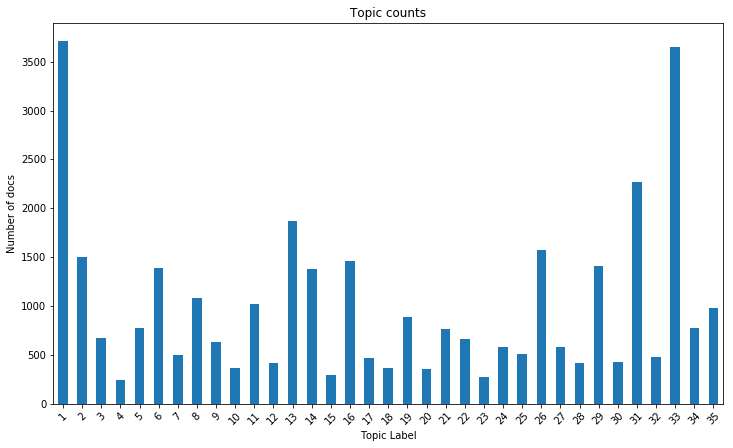

In [404]:
# plt.style.use('seaborn')
topics_count = pd.DataFrame(top_topic_ids, columns=['topic'])
topics_count = topics_count.reset_index().groupby('topic').count()
topics_count.reset_index(inplace=True)
topics_count['topic'] = topics_count['topic'].map(lambda x: topic_labels[x])
fig, ax = plt.subplots(figsize=(12, 7))
topics_count.plot(kind='bar', x='topic', y='index', ax=ax, rot=45)
ax.set(title='Topic counts', xlabel='Topic Label', ylabel='Number of docs')
ax.legend().set_visible(False)
plt.show()

### Topic per Complaints

In [405]:
top_word = {}
out_file = open('../datasets/topic_term_distributions.csv', 'w')
out_file.write('topic,topic_label,word_index,weight,word\n')
for i in range(NUM_TOPICS):
    topic_terms = ldamodel.get_topic_terms(i)
    top_word[i+1] = dictionary.id2token[topic_terms[0][0]]
    for term in topic_terms:
        out_file.write(str(i+1) + ',' + str(topic_labels[i+1]) + ',' + str(term[0]) + ',' + str(term[1]) + ',' + str(dictionary.id2token[term[0]]) + '\n')
out_file.close()

In [406]:
#ldamodel.get_topic_terms(23)

In [407]:
automatic_labels = [str(top_word[x]) for x in top_topic_ids]
top_topic_labels = [str(topic_labels[x]) for x in top_topic_ids]

temp_df = keywords_df.copy()
#keywords_df.drop(['tokens', 'finalized_tokens'], axis=1, inplace=True)
#keywords_df.drop(['ResolutionDescription','IssueDescription','ConcernDescription'],axis =1 , inplace=True)
temp_df['dominant_topic'] = top_topic_ids
temp_df['dominant_topic_probability'] = dominant_topic_prob
#keywords_df['automatic_topic_label'] = automatic_labels
temp_df['topic_label'] = top_topic_labels #manually labeled
temp_df['topic_distribution_string'] = doc_topics

# docs.to_csv('../datasets/annotated_docs.csv', index=False)



In [408]:
temp_df['Clause'] = complaints_df['Clause']
df = temp_df[['ConcernID','Clause','topic_label','dominant_topic_probability']]


In [409]:
df.sort_values('Clause',inplace=True)
df

,ConcernID,Clause,topic_label,dominant_topic_probability
131,973575,11,7,0.203333
28235,COM-510100,11,16,0.406115
30264,COM-92112,11,5,0.303621
19619,COM-490460,11,3,0.262179
13,969924,11,19,0.292549
14520,COM-482204,11,20,0.157529
36,970689,11,5,0.303788
31975,COM-95946,11,14,0.249939
11743,COM-478003,12_20,16,0.159533
24046,COM-497450,12_20,30,0.174814


In [410]:

import numpy as np
clause = np.array(df['Clause'])
topic_label = np.array(df['topic_label'])

In [411]:
final_df = pd.crosstab(clause,topic_label, rownames=['clause'], colnames=['topic_label'])
final_df.head()

topic_label,1,10,11,12,13,14,15,16,17,18,...,32,33,34,35,4,5,6,7,8,9
clause,,,,,,,,,,,,,,,,,,,,,
11,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,2,0,1,0,0
12_20,4,3,8,44,16,1,3,7,2,2,...,10,15,1,8,2,10,10,3,14,3
13,3,0,0,1,0,1,0,0,0,0,...,1,1,1,0,1,16,2,0,8,1
14a,380,22,189,66,1385,105,15,451,38,40,...,66,1890,372,460,72,88,114,31,268,191
14b,52,13,26,4,10,32,2,24,18,4,...,13,111,24,11,2,14,25,11,21,5


In [412]:
def get_keywords_per_clause(clause_name):
    cl_14a = final_df.loc[clause_name]
    mapper = dict(zip(cl_14a,cl_14a.index))
    cl_14_a = list(sorted(cl_14a,reverse=True))
    cl_14_b = [each for each in cl_14_a]
    top_3_topics = cl_14_b[:3]
    top_3_topic_names = [mapper[word] for word in top_3_topics]
    #print(top_3_topic_names)
    keywords = []
    for each in top_3_topic_names:
        topic2word= get_topics(ldamodel,NUM_TOPICS)
        words = topic2word[each]
        keywords.append(list(words))
    return flatten_lists(keywords)

def get_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn =15)
        word_dict['{}'.format(i+1)] = [i[0] for i in words]
        #word_dict['Topic # '+'{:2d}'.format(i+1)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

In [413]:
def write_to_csv(no_of_topics):
    with open('../datasets/keywords_per_clause_{}.csv'.format(no_of_topics), 'w') as f:
        Clauses = final_df.index
        for item in Clauses:
            f.write("Clause-{}\t : {} \n".format(item,get_keywords_per_clause(item)))
    

        
    

In [414]:
write_to_csv('35_nmf_usable')

In [431]:


import os, pandas as pd
# Add asset from file system
df_data_1 = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/keywords_per_clause_36_40_usable.csv')
df_data_1.head(20)



,Clause-11 : ['contact','information','provide','email','ask','need','response','refer','phone','time',...,'direct_debit','balance','debit','cancel','access_advantage','open','process','confirm','end','reinstate']
0,Clause-12_20\t : ['happy','apologise','provide','unhappy','receive','poor_service','want','send','feedback','service',...,'reverse','waive','happy','want','late_payment','reimburse','pay','gwg','unhappy','year']
1,Clause-13\t : ['send','receive','email','letter','request','statement','statements','mail','address','apologise',...,'concern','close','case','com','registration','email','offer','state','confirm','copy']
2,Clause-14a\t : ['fee','charge','credit','refund','annual_fee','reverse','waive','happy','want','late_payment',...,'allocate','annual_fee','rewards_black','year','receive','transfer','product','days','apply','rewards_platinum']
3,Clause-14b\t : ['fee','charge','credit','refund','annual_fee','reverse','waive','happy','want','late_payment',...,'need','response','refer','phone','time','number','team','want','concern','like']
4,Clause-15\t : ['happy','apologise','provide','unhappy','receive','poor_service','want','send','feedback','service',...,'open','apologise','closure','happy','visit','feedback_passed','want','staff_member','provide','feedback']
5,Clause-16\t : ['fee','charge','credit','refund','annual_fee','reverse','waive','happy','want','late_payment',...,'open','apologise','closure','happy','visit','feedback_passed','want','staff_member','provide','feedback']
6,Clause-17\t : ['fee','charge','credit','refund','annual_fee','reverse','waive','happy','want','late_payment',...,'try','work','come','ask','day','inform','happen','ring','issue','speak']
7,Clause-18\t : ['happy','apologise','provide','unhappy','receive','poor_service','want','send','feedback','service',...,'cause','apply','apologise','resolve','credit','open','progress_saver','lose','educate','unhappy']
8,Clause-18.1\t : ['point','frequent_flyer','bonus_points','apply','black','eligible','offer','credit','receive','platinum',...,'cause','apply','apologise','resolve','credit','open','progress_saver','lose','educate','unhappy']
9,Clause-18.2\t : ['happy','apologise','provide','unhappy','receive','poor_service','want','send','feedback','service',...,'concern','close','case','com','registration','email','offer','state','confirm','copy']


In [ ]:
# phrased = []
# for each in train_text_final:
#     phrased.append(get_phraser[each])

# keywords_df['finalized_tokens'] = phrased

In [ ]:
# from wordsegment import load, segment
# load()
# print(segment('providedcustomer'))

In [ ]:
#!pip install --user wordsegment

In [ ]:
# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()

# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer("english")

# def process_texts(tokens):
#     """Removes stop words, Stemming,
#        Lemmatization assuming verb"""
    
#     tokens = [token for token in tokens if token not in stop_words and custom_stopwords]
#     tokens = bigram_phraser[tokens]
#     tokens = trigram_phraser[tokens]
# #     tokens = [stemmer.stem(token) for token in tokens]
#     tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
#     return tokens

In [ ]:
# %matplotlib inline
# from nltk import FreqDist
# words = trigram_phraser[]
# fd =FreqDist(words)
# fd.plot(30,cumulative=False,title="Word Frequency")

In [ ]:
#bigram_phraser([[u'account', u'holder', u'of', u'new', u'york', u'was', u'there']])

In [ ]:
# from gensim.models import Phrases
# documents = ["the mayor of new york was there", "machine learning can be useful sometimes","new york mayor was present"]
# sentence_stream = [doc.split(" ") for doc in documents]
# bigram = Phrases(sentence_stream, min_count=1, threshold=3)
# sent = [u'account', u'holder', u'of', u'new', u'york', u'credit', u'card']
# print(bigram[sent])

In [ ]:
# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()

# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer("english")

# def process_texts(tokens):
#     """Removes stop words, Stemming,
#        Lemmatization assuming verb"""
    
#     tokens = [token for token in tokens if token not in stop_words]
#     tokens = bigram_phraser[tokens]
#     tokens = trigram_phraser[tokens]
# #     tokens = [stemmer.stem(token) for token in tokens]
#     tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
#     return tokens

In [ ]:
# %%time

# final_texts = []

# for line in train_texts:
#     final_texts.append(process_texts(line))

In [ ]:
# keywords_df['tokens'] = train_texts
# #keywords_df['tokens'][0]
# #set(keywords_df['tokens'][0])

In [ ]:
# from gingerit.gingerit import GingerIt
# parser = GingerIt()
# line="responses"
# tweet=parser.parse(line)
# lemmatizer.lemmatize(tweet['corrections'][0]['text'],pos='v')